In [1]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
import sklearn
from tqdm import tqdm
from BorutaShap import BorutaShap
import warnings
warnings.filterwarnings('ignore')

# print the JS visualization code to the notebook
shap.initjs()

D:\Python3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Python3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Python3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Python3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Read data

In [2]:
df = pd.read_csv('./train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   No.                               268 non-null    int64  
 1   T staging                         268 non-null    int64  
 2   N staging                         268 non-null    int64  
 3   Clinical staging                  268 non-null    int64  
 4   Gestation and production history  268 non-null    int64  
 5   Neoadjuvant chemotherapy          268 non-null    int64  
 6   Radiation therapy                 268 non-null    int64  
 7   Clavicular lymph nodes            268 non-null    int64  
 8   Posterior features                268 non-null    int64  
 9   No posterior features             268 non-null    int64  
 10  Enhancement                       268 non-null    int64  
 11  macrocalcification                268 non-null    int64  
 12  LNM     

In [3]:
df.head()

,No.,T staging,N staging,Clinical staging,Gestation and production history,Neoadjuvant chemotherapy,Radiation therapy,Clavicular lymph nodes,Posterior features,No posterior features,Enhancement,macrocalcification,LNM,1-year DM,2-year DM,3-year DM,DM,Time
0,4,2,0,2,1,0,0,0,1,1,0,0,0,0.0,0.0,1.0,1,32
1,6,1,0,1,1,0,0,0,2,0,1,0,1,0.0,0.0,0.0,0,120
2,7,2,0,2,1,0,0,1,1,1,0,0,0,0.0,0.0,0.0,1,51
3,8,2,1,2,1,0,1,0,3,0,0,0,0,0.0,0.0,0.0,0,116
4,9,2,1,2,1,0,1,0,3,0,0,0,1,0.0,0.0,0.0,0,129


In [4]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['DM']))}
class_mapping

{0: 0, 1: 1}

## Preprocessing

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

df['DM'] = df['DM'].map(class_mapping)
y = LabelEncoder().fit_transform(df['DM'].values)
X = df.iloc[:,1:13].values
print(y.shape)
print(X.shape)

(268,)
(268, 12)


In [6]:
features = df.columns[1:13]

In [7]:
df1 = pd.read_csv('./validation.csv')
class_mapping1 = {label: idx for idx, label in enumerate(np.unique(df1['DM']))}
df1['DM'] = df1['DM'].map(class_mapping1)
y1 = LabelEncoder().fit_transform(df1['DM'].values)
X1 = df1.iloc[:,1:13].values
print(y1.shape)
print(X1.shape)

(115,)
(115, 12)


In [8]:
df2 = pd.read_csv('./test.csv')
class_mapping2 = {label: idx for idx, label in enumerate(np.unique(df2['DM']))}
df2['DM'] = df2['DM'].map(class_mapping2)
y2 = LabelEncoder().fit_transform(df2['DM'].values)
X2 = df2.iloc[:,1:13].values
print(y2.shape)
print(X2.shape)

(48,)
(48, 12)


In [9]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_std = std.fit_transform(X)
X1_std = std.transform(X1)
X2_std = std.transform(X2)
print(X_std.shape)
print(X1_std.shape)
print(X2_std.shape)

(268, 12)
(115, 12)
(48, 12)


In [10]:
d_train = xgboost.DMatrix(X_std, label=y)
d_val = xgboost.DMatrix(X1_std, label=y1)
d_test = xgboost.DMatrix(X2_std, label=y2)

## Using XGB

In [17]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_val, "validation")], verbose_eval=100, early_stopping_rounds=100)

[0]	validation-logloss:0.418798
Will train until validation-logloss hasn't improved in 100 rounds.
[100]	validation-logloss:0.375258
[200]	validation-logloss:0.368903
[300]	validation-logloss:0.369013
Stopping. Best iteration:
[266]	validation-logloss:0.366542



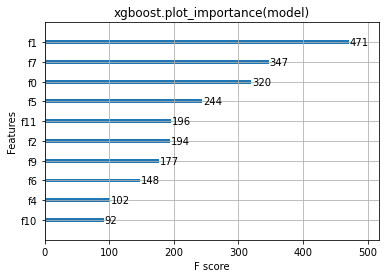

In [18]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

## SHAP analysis

In [23]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_std)

In [31]:
shap_values.shape

(268, 12)

In [27]:
shap_values[0,:].shape

(12,)

In [28]:
df.iloc[:,1:13].shape

(268, 12)

In [35]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_std[0,:])

In [36]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_std[:1000,:])

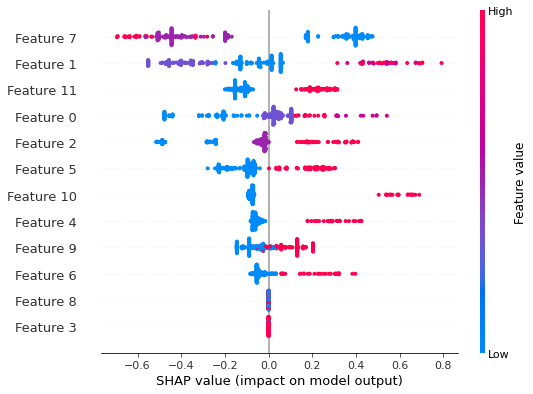

<Figure size 576x576 with 0 Axes>

In [53]:
shap.summary_plot(shap_values, X_std)
#plt.savefig('sfig1.jpg',dpi=1200)
#plt.show()

## Other modeling method

Accuracy: 84.35 % 


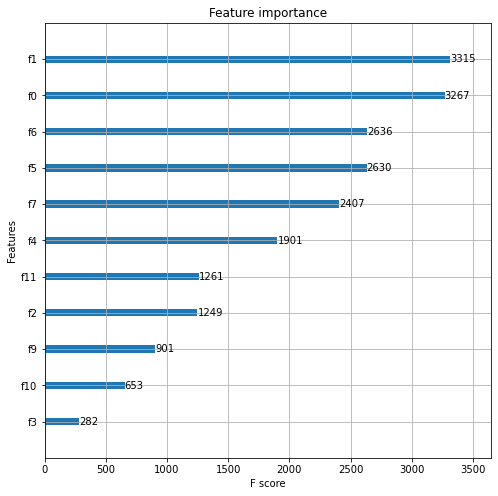

In [11]:
import matplotlib
import xgboost as xgb
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
# set XGBoost's parameters
params = {
    'booster': 'gbtree',
    #'objective': 'binary:hinge',  #'binary:logistic', 
    'objective':'multi:softmax',
    'eval_metric':'auc',
    'num_class': 2, 
    #'gamma': 0.1,
    'max_depth': 10,
    #'alpha':1,
    'lambda': 1,
    #'subsample': 1,
    #'colsample_bytree': 1,
    #'min_child_weight': 3,
    #'scale_pos_weight':4,
    #'silent': 1,
    'eta': 0.01,
    'seed': 100,
    #'nthread': 4,    
}

plst = params.items()
# trian
dtrain = xgb.DMatrix(X_std, y)
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds)

# test
dtest = xgb.DMatrix(X1_std)
ans = model.predict(dtest)

# calculate
cnt1 = 0
cnt2 = 0
for i in range(len(y1)):
    if ans[i] == y1[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))

# show the importance, for feature selection
xgb.plot_importance(model, importance_type='weight')
plt.savefig('sfig5.jpg',dpi=800)
plt.show()

## Save models

In [25]:
#from sklearn.externals import joblib
import joblib
#path = "F:/Experiments/YulanPeng/Wenwen/2023Run/DM/Experiments/Clinical"
joblib.dump(clf, "xgb.m")

['xgb.m']

In [26]:
joblib.dump(clf, "xgb.pkl")

['xgb.pkl']